# Remnant Parameter Estimation (SurfinBH)

In [1]:
import surfinBH
fit_name = 'NRSur3dq8Remnant'
fit = surfinBH.LoadFits(fit_name)

Loaded NRSur3dq8Remnant fit.


In [2]:
q = 1.24             # Mass ratio q>=1
chiA = [0,0,0]    # Spin of larger BH (z-direction only)
chiB = [0,0,0]    # Spin of smaller BH (z-direction only)

## Evaluate the fits and GPR error estimate.

# remnant mass and 1-sigma error estimate
mf, mf_err = fit.mf(q, chiA, chiB)

# remnant spin and 1-sigma error estimate
chif, chif_err = fit.chif(q, chiA, chiB)

# remnant recoil kick and 1-sigma error estimate
vf, vf_err = fit.vf(q, chiA, chiB)

# All of these together
mf, chif, vf, mf_err, chif_err, vf_err = fit.all(q, chiA, chiB)

In [26]:
# z-direction only
print(chif)
# mf is returning m2/m1...so multiply it by (m1+m2)
mf = mf*(36+29)
print(mf)

[0.         0.         0.68007186]
61.92344795441868


# IMR Time Domain Waveform

In [7]:
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries

In [39]:
hp, hc = get_td_waveform(approximant="IMRPhenomXP",
                         mass1=36,
                         mass2=29,
                         delta_t=1.0/16384,
                         f_lower=30,
                         distance=1e-14)

# sample times ---> timeseries
hp_smp_ts = TimeSeries(hp.sample_times, delta_t=1/16384, epoch=0)
# using crop on timeseries sample times - use cond for cropped sample times (aka ringdown analysis)
cond = hp_smp_ts.crop(0.645,0)                                      

# h+/hx data ---> timeseries
hp_data = TimeSeries(hp, delta_t=1/16384, epoch=0)  
# using crop on timeseries data (use cond_hp/hc for ringdown anaylsis)
cond_hp = hp_data.crop(0.645,0)
# turning into ndarray
hp_signal = cond_hp.numpy()                  

# repeat
hc_data = TimeSeries(hc, delta_t=1/16384, epoch=0)              
cond_hc = hc_data.crop(0.645,0)
hc_signal = cond_hc.numpy()                                         

# use for hp+hc ringdown analysis
time = cond.numpy()              

In [27]:
import matplotlib.pyplot as plt

(array([-8.e-05, -6.e-05, -4.e-05, -2.e-05,  0.e+00,  2.e-05,  4.e-05,
         6.e-05,  8.e-05,  1.e-04]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

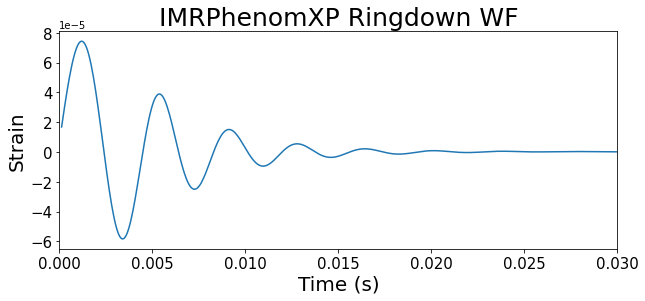

In [22]:
plt.figure(figsize=pylab.figaspect(0.4))
plt.plot(cond, cond_hc, label='IMR Cross')
plt.xlim(0, 0.03)
plt.title('IMRPhenomXP Ringdown WF',fontsize=25)
plt.xlabel('Time (s)',fontsize=20)
plt.ylabel('Strain',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [67]:
def rngdwn(time,M,chi,l,m,n,amplitude,phi):
    # using get_ftau to retrieve frequency and damping time for given values (ftau = [freq, tau])
    ftau = ringdown.qnms.get_ftau(M,chi,n,l,m)
    gamma = (ftau[1])**-1
    t0=0
        
    wf_kws = dict(
    A = amplitude,
    phi = phi,
    f = ftau[0],                                                            
    gamma = gamma,                                                          
    )
        
    def get_signal(time, A, phi, f, gamma):
        # generate sinusoid
        s = A*np.cos(2*np.pi*f*(time-t0) + phi)*np.exp(-gamma*abs(time-t0))
        return ringdown.Data(s, index=time)

    signal = get_signal(time, **wf_kws)
    
    return signal

In [68]:
import makefun

In [69]:
# define what modes to use
def rd_fun(modes=[(2,2,0),(2,2,1)]):
    #create function signature
    func_signature="rngdwn_multi_modes(time,M,chi"
    # loop through defined modes
    for mode in modes:
        l,m,n = mode
        func_signature+= f",amplitude{l}{m}{n},phi{l}{m}{n}"
    func_signature+=")"
    # kwargs = a220, phi220, a221, phi221, ...
    def new_fun(time,M,chi,**kwargs):
        # creating empty time array to hold rngdwn() return
        ex = np.zeros(time.shape)
        # loop through defined modes
        for mode in modes:
            l,m,n=mode
            # add back to empty time array
            ex += rngdwn(time,M,chi,l,m,n,amplitude,phi)
            print(time,M,chi,kwargs)
        # return ex to have combined signal for all defined modes
        return ex
    # this fx now looks like what scipy.curve_fit expects...
    return makefun.create_function(func_signature,new_fun)

# let "test = rd_fun" // test now takes inputs of (time,M,chi,a220,phi220,a221,phi221) --> curve_fit can play with
test = rd_fun()

# scipy.curve_fit

In [70]:
from scipy.optimize import curve_fit
import numpy as np

In [71]:
# xdata is time from IMR cell ^^^
xdata = time
# ydata is data from IMR cell ^^^
ydata = cond_hc
# p0 is my initial guesses
p0 = [62,0.68,1e-4,np.pi,1e-4,np.pi]
#using curve_fit
popt,pcov = curve_fit(test,xdata,ydata,p0,bounds=([50, .5, 1e-6, 0, 1e-6, 0], [80, .85, 1e-3, 2*np.pi, 1e-3, 2*np.pi]))


NameError: name 'amplitude' is not defined